# QDM Diagnostics (with some BCSD sprinkled in)

Feb 2021

Notebook currently contains initial exploration, including the effect of the number of quantiles on the results of QDM. Adapted from `test_xclim_qdm.ipynb` 

The goal is to more systematically implement the <a href="https://paper.dropbox.com/doc/QDM-diagnostics--BFVDLE_QJVx4jBHStMsAjbGxAg-a1WGGhdbaNbzndzTiFFVP">QDM Diagnostics</a> in this notebook


Note: the notebook installs `xclim` from a local clone that can be edited (hence a bunch of debugging output below). 
TODO: move the `xclim` debugging into a different notebook

In [24]:
pip install -e /home/jovyan/xclim 

Obtaining file:///home/jovyan/xclim
  Running setup.py develop for xclim
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix

  Cloning https://github.com/dgergel/xsd.git (to revision pointwisedownscaler_interimfix) to /tmp/pip-req-build-ilyoam1w
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-downscale: filename=scikit_downscale-0.0.1.post262-py3-none-any.whl size=22370 sha256=4cdad94e73a688c86039995e75ce6fae8d315dade4574537ec68cd60e9e837c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rca6sfm6/wheels/31/9a/21/7637b2b133bbb6aa5a89cab830ed35b8bd59ca457f8b4fdc98
Successfully built scikit-downscale
Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 

import intake
import xesmf as xe

from utils import _convert_lons, _remove_leap_days, _convert_ds_longitude
from regridding import apply_weights

In [2]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [3]:
write_direc = '../figures/' #'/gcs/rhg-data/climate/downscaled/workdir'

In [4]:
# this pulls in sample data which is part of this repo but was taken from scikit-downscale. Includes training data taken from a 50km WRF run over North America and the obs data is sampled from 
# the nearest 1/16th deg grid cell from Livneh et al 2013
from utils import get_sample_data

In [5]:
import xclim
from xclim import sdba
from skdownscale.pointwise_models import PointWiseDownscaler, BcsdTemperature

In [6]:
# training = historical model data, targets = obs data 
training = get_sample_data('training')
targets = get_sample_data('targets')

# get necessary datasets: target, training, and predict and select appropriate times
# define time slices 
# original training data goes from 1979/01 - 2015/11
train_slice = slice('1979-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '2014-12-31')

ds_train = training['tmax'][train_slice].to_xarray()
ds_target = targets['tmax'][train_slice].to_xarray()
ds_predict = training['tmax'][predict_slice].to_xarray()


now start to actually fit models 

## BCSD 

In [7]:
bcsd = PointWiseDownscaler(BcsdTemperature(return_anoms=False))

# time grouper --> NASA-NEX method 
bcsd_nasanex = PointWiseDownscaler(BcsdTemperature(return_anoms=False, time_grouper='daily_nasa-nex'))

# actually fitting the model 
bcsd.fit(ds_train, ds_target) # default BCSD grouping
bcsd_nasanex.fit(ds_train, ds_target) # nasa-nex grouping

# actually predicting using the BCSD model 
bcsd_predicted = bcsd.predict(ds_predict).load()
bcsd_predicted_hist = bcsd.predict(ds_train).load() # adjusting training
bcsd_nasanex_predicted = bcsd_nasanex.predict(ds_predict).load()
bcsd_nasanex_predicted_hist = bcsd_nasanex.predict(ds_train).load() # adjusting training



## QDM 

In [8]:
import importlib

In [13]:
importlib.reload(xclim)

<module 'xclim' from '/home/jovyan/xclim/xclim/__init__.py'>

In [12]:
# instantiates a grouper class which allows you to group by day of the year 
# window is centered: 31 is the +/-15 day group 
window = 31
group = sdba.Grouper('time.dayofyear', window=window)

# initiates a qdm model class 
qdm20 = sdba.adjustment.QuantileDeltaMapping(group=group, kind='+')
qdm100 = sdba.adjustment.QuantileDeltaMapping(group=group, kind='+',nquantiles=100)
qdme = sdba.adjustment.QuantileDeltaMapping(group=group, kind='+', 
                                            nquantiles=window*len(ds_predict.groupby("time.year")))

# train the models: Model Training data onto Obs Target
qdm20.train(ds_train, ds_target)
qdm100.train(ds_train, ds_target)
qdme.train(ds_train, ds_target)

In [13]:
# apply the QDM corrections, including to the training data (just for valition, it's not really legit)
# adjust the predict dataset to the training
qdm20_adjusted_da = qdm20.adjust(ds_predict)
qdm20_histadjusted_da = qdm20.adjust(ds_train) 
qdm100_adjusted_da = qdm100.adjust(ds_predict)
qdm100_histadjusted_da = qdm100.adjust(ds_train) 
qdme_adjusted_da = qdme.adjust(ds_predict)
qdme_histadjusted_da = qdme.adjust(ds_train) 

# Don't mind the output here -- I put debugging messages into xclim

_adjust(), af <xarray.DataArray 'af' (quantiles: 24, dayofyear: 366)>
array([[-7.15781966, -7.15782031, -7.15782095, ..., -7.15782683,
        -7.15782616, -2.95195354],
       [-7.15781966, -7.15782031, -7.15782095, ..., -7.15782683,
        -7.15782616, -2.95195354],
       [-1.28268367, -1.18125932, -1.1794062 , ..., -1.46831765,
        -1.46643353, -2.2745133 ],
       ...,
       [ 1.29950261,  1.29421568,  1.48803153, ...,  0.87661314,
         0.93850636,  0.61849394],
       [ 0.28471991,  0.28471998,  0.60018344, ...,  0.28471998,
         0.28471991,  0.40470794],
       [ 0.28471991,  0.28471998,  0.60018344, ...,  0.28471998,
         0.28471991,  0.40470794]])
Coordinates:
  * quantiles  (quantiles) float64 0.0 1e-06 0.025 0.075 ... 0.925 0.975 1.0 1.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    group:               time.dayofyear
    group_compute_dims:  ['time', 'window']
    group_window:        31
    kind:         

Text(0.5, 1.0, 'ref_q (target)')

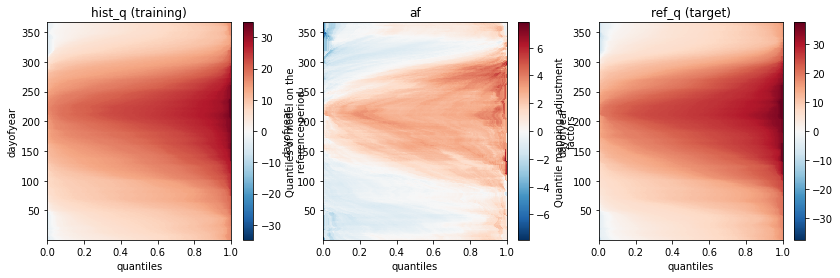

In [14]:
fig,axs=plt.subplots(1,3,figsize=(14,4))
qdme.ds.hist_q.plot(ax=axs[0])
axs[0].set_title("hist_q (training)")
qdme.ds.af.plot(ax=axs[1])
axs[1].set_title("af")
(qdme.ds.hist_q+qdme.ds.af).plot(ax=axs[2])
axs[2].set_title("ref_q (target)")


## compare effect of quantiles on QDM
Look at adjustment factors by quantile and day of year first

Text(0.5, 1.0, 'adjustment factors (empirical q)')

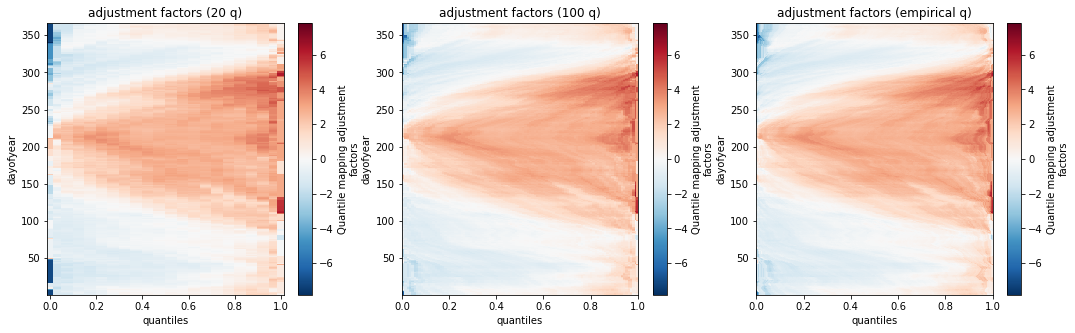

In [34]:
fig,axs=plt.subplots(1,3,figsize=(18,5))
qdm20.ds.af.plot(ax=axs[0])
axs[0].set_title("adjustment factors (20 q)")
qdm100.ds.af.plot(ax=axs[1])
axs[1].set_title("adjustment factors (100 q)")
qdme.ds.af.plot(ax=axs[2])
axs[2].set_title("adjustment factors (empirical q)")


Compare adjustment factors for key quantiles 

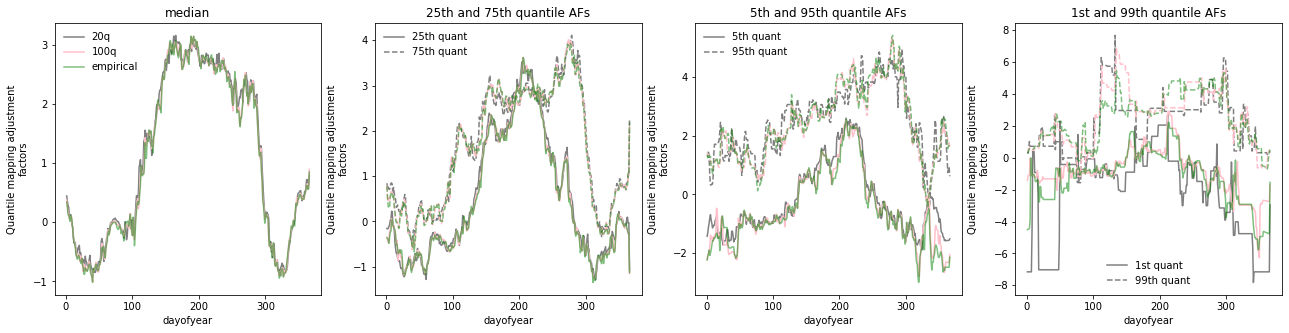

In [42]:
fig,axs = plt.subplots(1,4, figsize=(22, 5))
ax=axs[0]
qdm20.ds.af.sel(quantiles=.5, method='nearest').plot(ax=ax,color='gray', linestyle='-')
qdm100.ds.af.sel(quantiles=.5, method='nearest').plot(ax=ax,color='pink', linestyle='-')
qdme.ds.af.sel(quantiles=.5, method='nearest').plot(ax=ax,color='green', linestyle='-',alpha=.5)
ax.legend(('20q','100q','empirical'),frameon=False)
_ = ax.set_title('median')
ax=axs[1]
qdm20.ds.af.sel(quantiles=.25, method='nearest').plot(ax=ax,color='gray', linestyle='-')
qdm20.ds.af.sel(quantiles=.75, method='nearest').plot(ax=ax,color='gray', linestyle='--')
qdm100.ds.af.sel(quantiles=.25, method='nearest').plot(ax=ax,color='pink', linestyle='-')
qdm100.ds.af.sel(quantiles=.75, method='nearest').plot(ax=ax,color='pink', linestyle='--')
qdme.ds.af.sel(quantiles=.25, method='nearest').plot(ax=ax,color='green', linestyle='-',alpha=.5)
qdme.ds.af.sel(quantiles=.75, method='nearest').plot(ax=ax,color='green', linestyle='--', alpha=.5)
_ = ax.set_title('25th and 75th quantile AFs')
ax.legend(('25th quant','75th quant'),frameon=False)
ax=axs[2]
qdm20.ds.af.sel(quantiles=.05, method='nearest').plot(ax=ax,color='gray', linestyle='-')
qdm20.ds.af.sel(quantiles=.95, method='nearest').plot(ax=ax,color='gray', linestyle='--')
qdm100.ds.af.sel(quantiles=.05, method='nearest').plot(ax=ax,color='pink', linestyle='-')
qdm100.ds.af.sel(quantiles=.95, method='nearest').plot(ax=ax,color='pink', linestyle='--')
qdme.ds.af.sel(quantiles=.05, method='nearest').plot(ax=ax,color='green', linestyle='-',alpha=.5)
qdme.ds.af.sel(quantiles=.95, method='nearest').plot(ax=ax,color='green', linestyle='--', alpha=.5)
_ = ax.set_title('5th and 95th quantile AFs')
ax.legend(('5th quant','95th quant'),frameon=False)
ax=axs[3]
qdm20.ds.af.sel(quantiles=.01, method='nearest').plot(ax=ax,color='gray', linestyle='-')
qdm20.ds.af.sel(quantiles=.99, method='nearest').plot(ax=ax,color='gray', linestyle='--')
qdm100.ds.af.sel(quantiles=.01, method='nearest').plot(ax=ax,color='pink', linestyle='-')
qdm100.ds.af.sel(quantiles=.99, method='nearest').plot(ax=ax,color='pink', linestyle='--')
qdme.ds.af.sel(quantiles=.01, method='nearest').plot(ax=ax,color='green', linestyle='-',alpha=.5)
qdme.ds.af.sel(quantiles=.99, method='nearest').plot(ax=ax,color='green', linestyle='--', alpha=.5)
_ = ax.set_title('1st and 99th quantile AFs')
ax.legend(('1st quant','99th quant'),frameon=False)



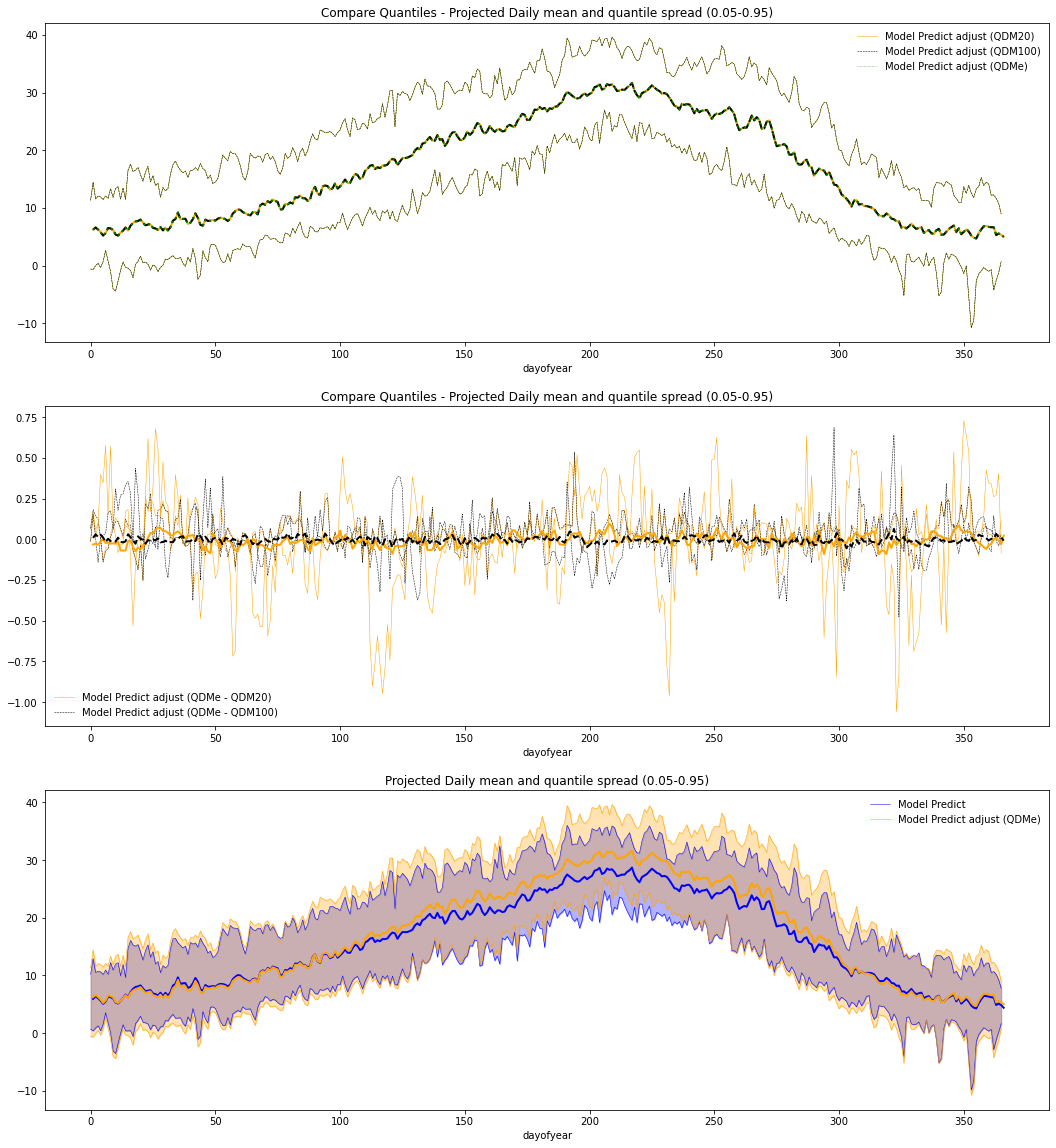

In [19]:
fig,axs = plt.subplots(3,1, figsize=(18, 20))
ax=axs[0]
# ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.05), 
#         linewidth=.5, color='blue')
ax.plot(np.arange(len(qdm20_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='black', linestyle='dashed')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='green', linestyle=':')
# ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.95), 
#         linewidth=.5, color='blue')
ax.plot(np.arange(len(qdm20_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='black', linestyle='dashed')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='green', linestyle=':')

# ds_predict.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='blue')#, alpha=.7)
qdm20_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='orange')#, alpha=.7)
qdm100_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='black', linestyle='dashed')#, alpha=.7)
qdme_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='green', linestyle=':')#, alpha=.7)

ax.legend(('Model Predict adjust (QDM20)',
          'Model Predict adjust (QDM100)',
          'Model Predict adjust (QDMe)'), frameon=False)
_ = ax.set_title('Compare Quantiles - Adjusted Daily mean and quantile spread (0.05-0.95)')

ax=axs[1]
ax.plot(np.arange(len(qdm20_adjusted_da.groupby('time.dayofyear'))), (qdme_adjusted_da.groupby('time.dayofyear').quantile(.05)
                                                                      -qdm20_adjusted_da.groupby('time.dayofyear').quantile(.05)), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), (qdme_adjusted_da.groupby('time.dayofyear').quantile(.05)
                                                                       -qdm100_adjusted_da.groupby('time.dayofyear').quantile(.05)), 
        linewidth=.5, color='black', linestyle='dashed')
ax.plot(np.arange(len(qdm20_adjusted_da.groupby('time.dayofyear'))), (qdme_adjusted_da.groupby('time.dayofyear').quantile(.95)
                                                                      - qdm20_adjusted_da.groupby('time.dayofyear').quantile(.95)), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(qdm100_adjusted_da.groupby('time.dayofyear'))), (qdme_adjusted_da.groupby('time.dayofyear').quantile(.95)
                                                                       - qdm100_adjusted_da.groupby('time.dayofyear').quantile(.95)), 
        linewidth=.5, color='black', linestyle='dashed')

(qdme_adjusted_da.groupby('time.dayofyear').mean()
 - qdm20_adjusted_da.groupby('time.dayofyear').mean()).plot(ax=ax, linewidth=2, color='orange')#, alpha=.7)
(qdme_adjusted_da.groupby('time.dayofyear').mean()
 - qdm100_adjusted_da.groupby('time.dayofyear').mean()).plot(ax=ax, linewidth=2, color='black', linestyle='dashed')#, alpha=.7)

ax.legend(('Model Predict adjust (QDMe - QDM20)',
          'Model Predict adjust (QDMe - QDM100)'), frameon=False)
_ = ax.set_title('Compare Quantiles - Difference of Adjusted Daily mean and quantile spread (0.05-0.95) from QDMe')


ax=axs[2]
ax.fill_between(np.arange(len(ds_predict.groupby('time.dayofyear'))), 
                ds_predict.groupby('time.dayofyear').quantile(.05), 
                ds_predict.groupby('time.dayofyear').quantile(.95), alpha=.3, color='blue')
ax.fill_between(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), 
                qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
                qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), alpha=.3, color='orange')
ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='orange')

ds_predict.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='blue')#, alpha=.7)
qdme_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='orange')#, alpha=.7)

ax.legend(('Model Predict',
          'Model Predict adjust (QDMe)'), frameon=False)
_ = ax.set_title('Projected Daily mean and quantile spread (0.05-0.95)')






## Look at effect of applying QDM with empirical quantiles (QDMe) to model data 

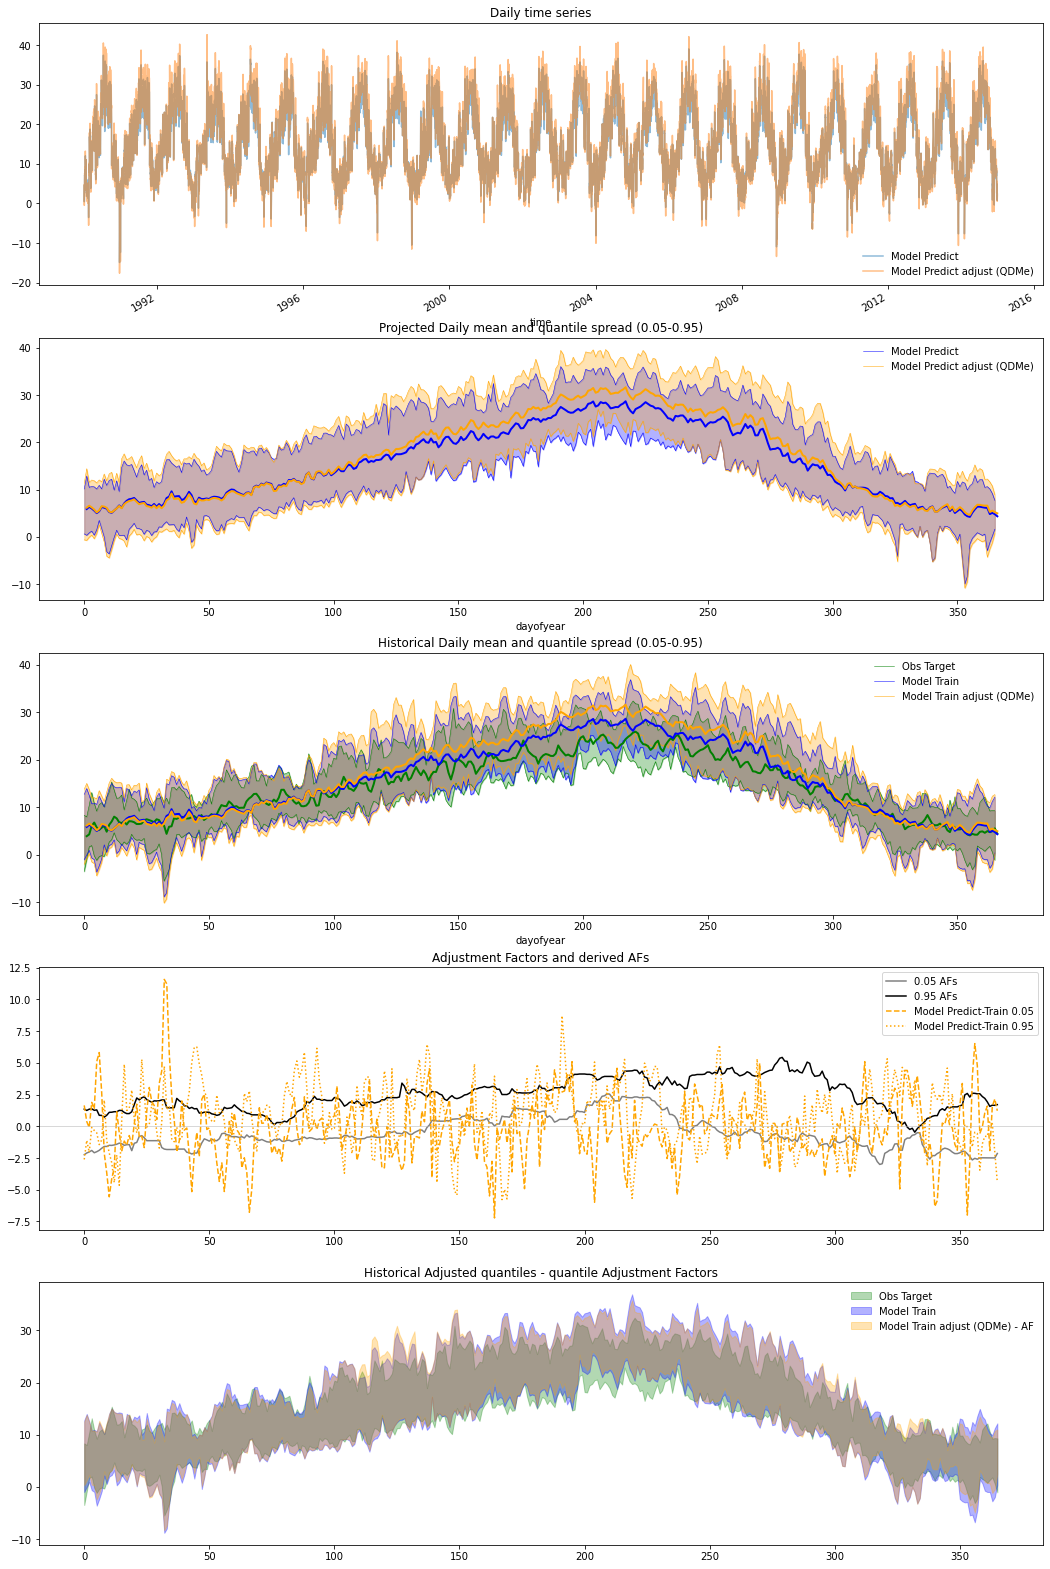

In [194]:
fig,axs = plt.subplots(5,1, figsize=(18, 28))
ax=axs[0]
ds_predict.plot(ax=ax, alpha=.5)
qdme_adjusted_da.plot(ax=ax, alpha=.5)
_ = ax.set_title('Daily time series')
ax.legend(('Model Predict', 'Model Predict adjust (QDMe)'), frameon=False)

ax=axs[1]
ax.fill_between(np.arange(len(ds_predict.groupby('time.dayofyear'))), 
                ds_predict.groupby('time.dayofyear').quantile(.05), 
                ds_predict.groupby('time.dayofyear').quantile(.95), alpha=.3, color='blue')
ax.fill_between(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), 
                qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
                qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), alpha=.3, color='orange')
ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='orange')
ax.plot(np.arange(len(ds_predict.groupby('time.dayofyear'))), ds_predict.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_adjusted_da.groupby('time.dayofyear'))), qdme_adjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='orange')

ds_predict.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='blue')#, alpha=.7)
qdme_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='orange')#, alpha=.7)

ax.legend(('Model Predict',
          'Model Predict adjust (QDMe)'), frameon=False)
_ = ax.set_title('Projected Daily mean and quantile spread (0.05-0.95)')

ax=axs[2]
ax.fill_between(np.arange(len(ds_target.groupby('time.dayofyear'))), 
                ds_target.groupby('time.dayofyear').quantile(.05), 
                ds_target.groupby('time.dayofyear').quantile(.95), alpha=.3, color='green')
ax.fill_between(np.arange(len(ds_train.groupby('time.dayofyear'))), 
                ds_train.groupby('time.dayofyear').quantile(.05), 
                ds_train.groupby('time.dayofyear').quantile(.95), alpha=.3, color='blue')
ax.fill_between(np.arange(len(qdme_histadjusted_da.groupby('time.dayofyear'))), 
                qdme_histadjusted_da.groupby('time.dayofyear').quantile(.05), 
                qdme_histadjusted_da.groupby('time.dayofyear').quantile(.95), alpha=.3, color='orange')
ax.plot(np.arange(len(ds_target.groupby('time.dayofyear'))), ds_target.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='green')
ax.plot(np.arange(len(ds_train.groupby('time.dayofyear'))), ds_train.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_histadjusted_da.groupby('time.dayofyear'))), qdme_histadjusted_da.groupby('time.dayofyear').quantile(.05), 
        linewidth=.5, color='orange')

ax.plot(np.arange(len(ds_target.groupby('time.dayofyear'))), ds_target.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='green')
ax.plot(np.arange(len(ds_train.groupby('time.dayofyear'))), ds_train.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='blue')
ax.plot(np.arange(len(qdme_histadjusted_da.groupby('time.dayofyear'))), qdme_histadjusted_da.groupby('time.dayofyear').quantile(.95), 
        linewidth=.5, color='orange')

ds_target.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='green')#, alpha=.7)
ds_predict.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='blue')#, alpha=.7)
qdme_adjusted_da.groupby('time.dayofyear').mean().plot(ax=ax, linewidth=2, color='orange')#, alpha=.7)

ax.legend(('Obs Target',
           'Model Train',
          'Model Train adjust (QDMe)'), frameon=False)
_ = ax.set_title('Historical Daily mean and quantile spread (0.05-0.95)')

ax=axs[3]
ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.05), method='nearest'), color='0.5')
ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.95), method='nearest'), color='k')

# @@@@ TODO can't really do this b/c the actual method groups by +/-15 days
ax.plot(ds_predict.groupby('time.dayofyear').quantile(.05) 
        - ds_train.groupby('time.dayofyear').quantile(.05), color='orange', linestyle='dashed')
ax.plot(ds_predict.groupby('time.dayofyear').quantile(.95) 
        - ds_train.groupby('time.dayofyear').quantile(.95), color='orange', linestyle='dotted')

ax.axhline(y=0, color='.7', linewidth=.5)
ax.legend(('0.05 AFs', '0.95 AFs', 'Model Predict-Train 0.05', 'Model Predict-Train 0.95'))
_ = ax.set_title('Adjustment Factors and derived AFs (**see caveat)')

ax=axs[4]
ax.fill_between(np.arange(len(ds_target.groupby('time.dayofyear'))), 
                ds_target.groupby('time.dayofyear').quantile(.05), 
                ds_target.groupby('time.dayofyear').quantile(.95), alpha=.3, color='green')
ax.fill_between(np.arange(len(ds_train.groupby('time.dayofyear'))), 
                ds_train.groupby('time.dayofyear').quantile(.05), 
                ds_train.groupby('time.dayofyear').quantile(.95), alpha=.3, color='blue')
ax.fill_between(np.arange(len(qdme_histadjusted_da.groupby('time.dayofyear'))), 
                (qdme_histadjusted_da.groupby('time.dayofyear').quantile(.05)
                 - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.05), method='nearest')), 
                (qdme_histadjusted_da.groupby('time.dayofyear').quantile(.95)
                 - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.95), method='nearest')), alpha=.3, color='orange')
_ = ax.set_title('Historical Adjusted quantiles - quantile Adjustment Factors (**see caveat)')
ax.legend(('Obs Target', 
           'Model Train', 
           'Model Train adjust (QDMe) - AF'), frameon=False)

fig.savefig('{}QDM_diagnostics_dailytimeseries_dailyquantiles_adjustmentfactors.png'.format(write_direc), dpi=100, bbox_inches='tight')

### Notes on above Figure
- Model Train versus Target (row 3): at the mean, the model training period is not too different from the observed target during the winter and spring, but is warmer than the observations during summer and into fall (row 3, green and blue lines). The quantile spread is a little wider in the model than the target (compare green and blue shading in row 3).
- Applying QDM on Model Predict (row 2): this is the output of bias correction - to correct future model projections to the Target
    - raises temps for tails and the mean during summer
    - widen the quantile spread during non-summer seasons with approx no effect on the mean
- Applying QDM on Model Train (row 3): this allows us to compare directly the "corrected" model to the Target
    - raises the temperature in the mean during summer, with little change in other parts of the year
    - appears to widen the quantile spread most of the year, except maybe summer where everything is made warmer
    - This seems almost like the QDM is pulling the corrected model *away* from the Target → <strike>but note that the AFs are the deltas and in the adjusted model data, they are added to the model training data, which is a bit weird given it’s the same time period and there wouldn’t be any trends. Maybe not the best comparison. See row 5 instead ?</strike>
- Adjustment factors (row 4): <strike>this is the delta</strike> - how much the quantiles in the model change from the <strike>Training period to the Predict period</strike>model training to obs target (Target - Training). <strike>Here there is one set of AFs because we are using just one CDF to do the prediction correction (not one for each year).</strike> In our method, we will have a set of AFs for each year and they will represent the change from model prediction to model training. Also showing "derived adjustment factors" which is just the model predict quantile by dayofyear minus model train quantile by dayofyear. (of course we now know this isn't quite right - `xclim` appears to actually compute af's as obs-target minus model-train.) Also see **caveat** about derived adjustment factors
    - <strike>AFs of the 0.95 quantile are positive, meaning the warm tail gets warmer into the future in the model</strike>
    - <strike>AFs of the 0.05 quantile are positive in summer and negative otherwise --> this means the cold tail gets warmer only in summer, but actually gets colder in other seasons, leading to a wider spread in the future during those months</strike>
- Applying only the quantile mapping step of QDM (row 5) (we get this by subtracting the AFs from model-training data - see **caveat**):
    - shows slight adjustments of the quantile mapping that slightly narrow the spread in summer and maybe winter but hard to pick out any real patterns otherwise (?)
    
    
### Addendum:
After this analysis, I discovered that the AFs are actually the (target - training) values in quantile space. QDM here doesn't appear to compute AFs with the prediction time series. Therefore some of what was originally written above doesn't apply. (Also, I'm confused about the sign of the AFs since they are computed as `ref_q - hist_q` but are positive in summer and seem to pull the Training further from the Target in the training period? --> I feel like the AFs should actually be `hist_q - ref_q`

### Caveat:
The AFs are computed over the quantiles that were created using rolling windows (31 days), whereas the comparisons in the above figure are with means and quantiles that are just daily (no rolling window applied), so they are slightly different. So combining AFs and adjusted daily quantiles (ie. subtracting the AFs from adjusted data) is not quite right



## Look at QDM and BCSD together

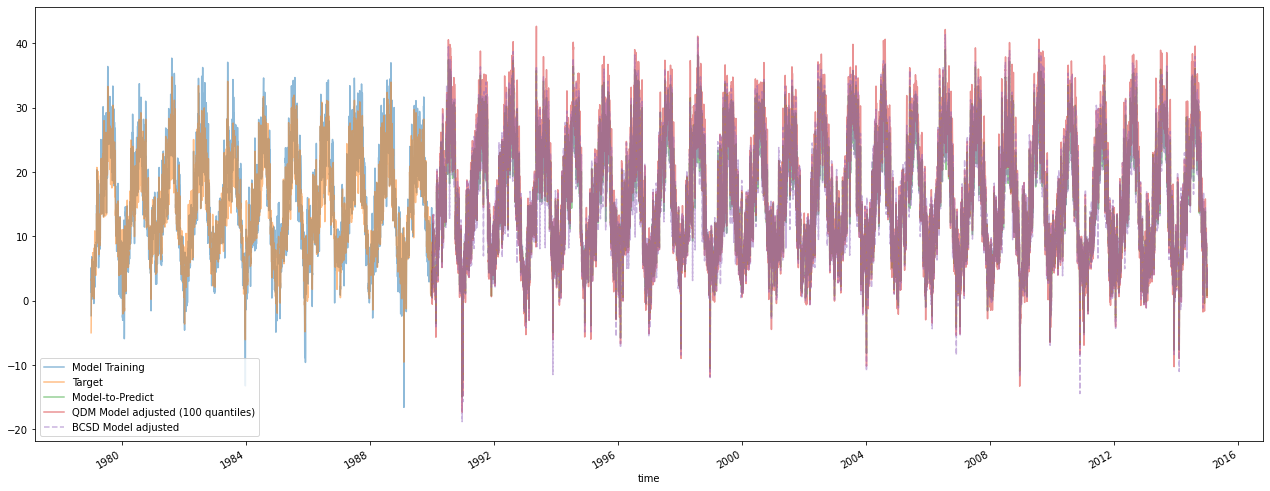

In [44]:
fig,ax = plt.subplots(1,1,figsize=(22,8))
ds_train.plot(ax=ax, alpha=.5)
ds_target.plot(ax=ax, alpha=.5)
ds_predict.plot(ax=ax, alpha=.5)
qdm100_adjusted_da.plot(ax=ax, alpha=.5)
bcsd_nasanex_predicted.plot(ax=ax, alpha=.5, linestyle='dashed')
ax.legend(('Model Training', 'Target', 'Model-to-Predict', 'QDM Model adjusted (100 quantiles)', 'BCSD Model adjusted'))

In [49]:
colordt = {'Train': 'blue',
          'Target': '0.3',
          'Predict': 'green',
          'QDMe Train': 'magenta',
          'QDM20': 'cyan',
          'QDM100': 'red',
           'QDMe': 'orange',
          'BCSDNN': 'purple'}

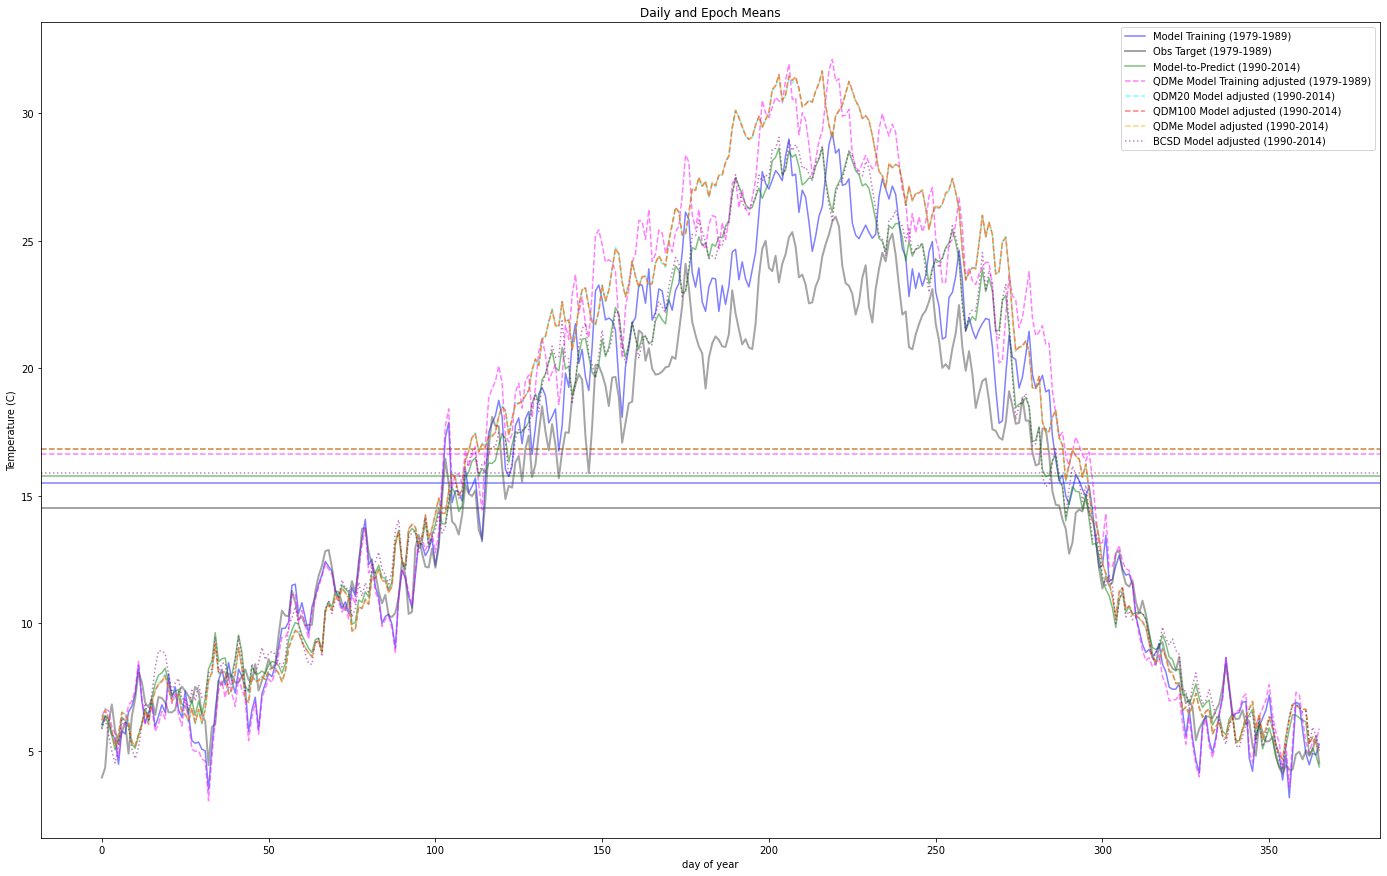

In [50]:
fig,ax = plt.subplots(1,1,figsize=(24,15))
# means over the whole time series
ax.axhline(ds_train.mean(dim='time'), color=colordt['Train'],alpha=.5)
ax.axhline(ds_target.mean(dim='time'), color=colordt['Target'], alpha=.5, linewidth=2)
ax.axhline(ds_predict.mean(dim='time'), color=colordt['Predict'], alpha=.5)

ax.axhline(qdme_histadjusted_da.mean(dim='time'), color=colordt['QDMe Train'], alpha=.5, linestyle='dashed')

ax.axhline(qdm20_adjusted_da.mean(dim='time'), color=colordt['QDM20'], alpha=.5, linestyle='dashed')
ax.axhline(qdm100_adjusted_da.mean(dim='time'), color=colordt['QDM100'], alpha=.5, linestyle='dashed')
ax.axhline(qdme_adjusted_da.mean(dim='time'), color=colordt['QDMe'], alpha=.5, linestyle='dashed')
ax.axhline(bcsd_nasanex_predicted.mean(dim='time'), color=colordt['BCSDNN'], alpha=.5, linestyle=':')

# daily means
ax.plot(ds_train.groupby("time.dayofyear").mean(dim='time'), color=colordt['Train'], alpha=.5)
ax.plot(ds_target.groupby("time.dayofyear").mean(dim='time'), color=colordt['Target'], alpha=.5, linewidth=2)
ax.plot(ds_predict.groupby("time.dayofyear").mean(dim='time'), color=colordt['Predict'], alpha=.5)

ax.plot(qdme_histadjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDMe Train'], alpha=.5, linestyle='dashed')

ax.plot(qdm20_adjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDM20'], alpha=.5, linestyle='dashed')
ax.plot(qdm100_adjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDM100'], alpha=.5, linestyle='dashed')
ax.plot(qdme_adjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDMe'], alpha=.5, linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby("time.dayofyear").mean(dim='time'), color=colordt['BCSDNN'], alpha=.5, linestyle=':')

ax.legend(('Model Training (1979-1989)', 
           'Obs Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDM20 Model adjusted (1990-2014)',
           'QDM100 Model adjusted (1990-2014)', 
           'QDMe Model adjusted (1990-2014)',
           'BCSD Model adjusted (1990-2014)'))
_ = ax.set_title('Daily and Epoch Means')
ax.set_xlabel('day of year')
ax.set_ylabel('Temperature (C)')
fig.savefig('{}/bias_correction_dailymeanclimo_comparison_testdata.png'.format(write_direc), dpi=100, bbox_inches='tight')


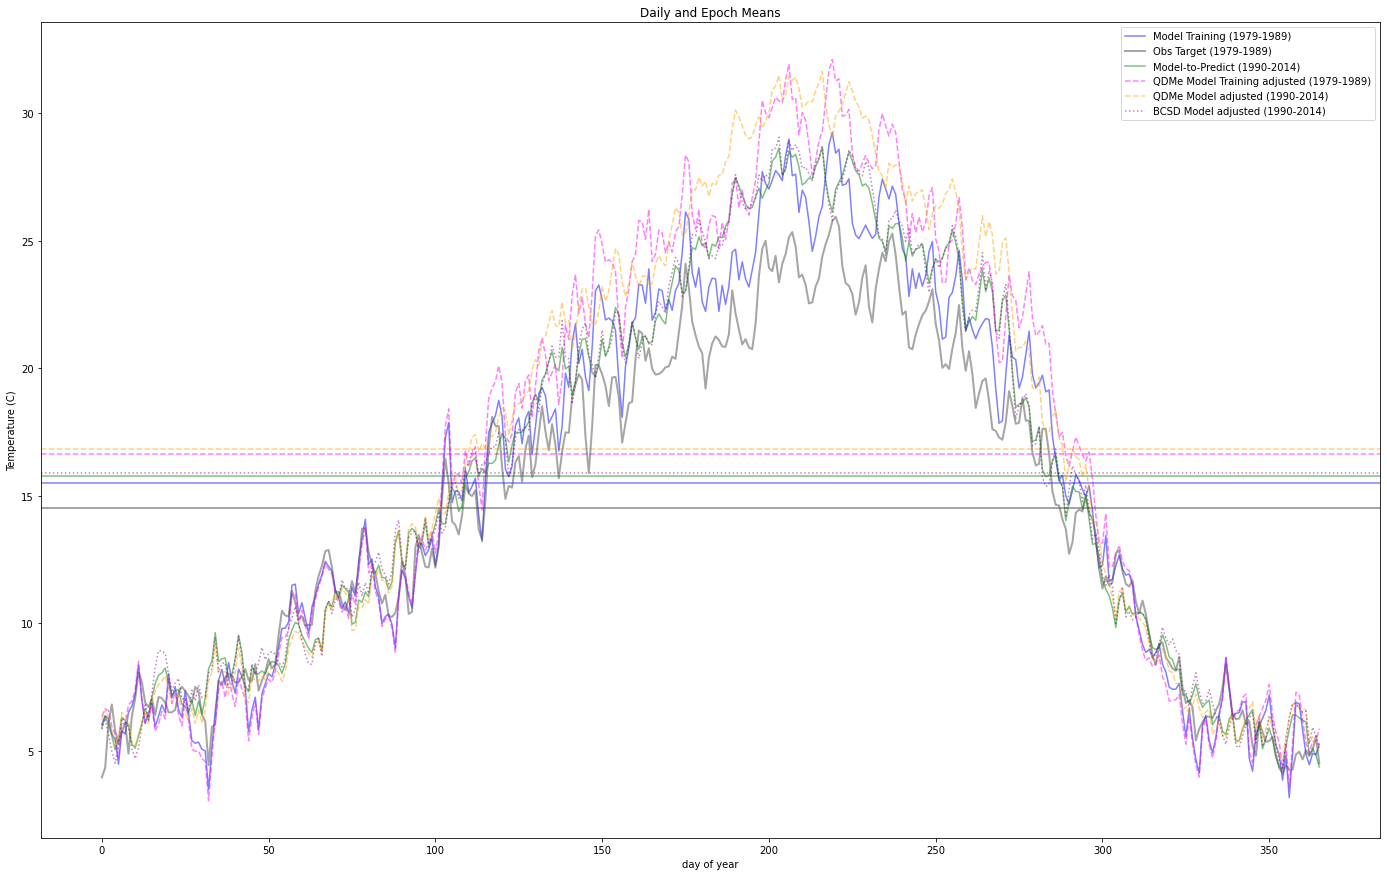

In [51]:
fig,ax = plt.subplots(1,1,figsize=(24,15))
# means over the whole time series
ax.axhline(ds_train.mean(dim='time'), color=colordt['Train'],alpha=.5)
ax.axhline(ds_target.mean(dim='time'), color=colordt['Target'], alpha=.5, linewidth=2)
ax.axhline(ds_predict.mean(dim='time'), color=colordt['Predict'], alpha=.5)

ax.axhline(qdme_histadjusted_da.mean(dim='time'), color=colordt['QDMe Train'], alpha=.5, linestyle='dashed')

ax.axhline(qdme_adjusted_da.mean(dim='time'), color=colordt['QDMe'], alpha=.5, linestyle='dashed')
ax.axhline(bcsd_nasanex_predicted.mean(dim='time'), color=colordt['BCSDNN'], alpha=.5, linestyle=':')

# daily means
ax.plot(ds_train.groupby("time.dayofyear").mean(dim='time'), color=colordt['Train'], alpha=.5)
ax.plot(ds_target.groupby("time.dayofyear").mean(dim='time'), color=colordt['Target'], alpha=.5, linewidth=2)
ax.plot(ds_predict.groupby("time.dayofyear").mean(dim='time'), color=colordt['Predict'], alpha=.5)

ax.plot(qdme_histadjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDMe Train'], alpha=.5, linestyle='dashed')

ax.plot(qdme_adjusted_da.groupby("time.dayofyear").mean(dim='time'), color=colordt['QDMe'], alpha=.5, linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby("time.dayofyear").mean(dim='time'), color=colordt['BCSDNN'], alpha=.5, linestyle=':')

ax.legend(('Model Training (1979-1989)', 
           'Obs Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDMe Model adjusted (1990-2014)',
           'BCSD Model adjusted (1990-2014)'))
_ = ax.set_title('Daily and Epoch Means')
ax.set_xlabel('day of year')
ax.set_ylabel('Temperature (C)')

fig.savefig('{}/bias_correction_dailymeanclimo_qdme_bcsd_comparison_testdata.png'.format(write_direc), dpi=100, bbox_inches='tight')


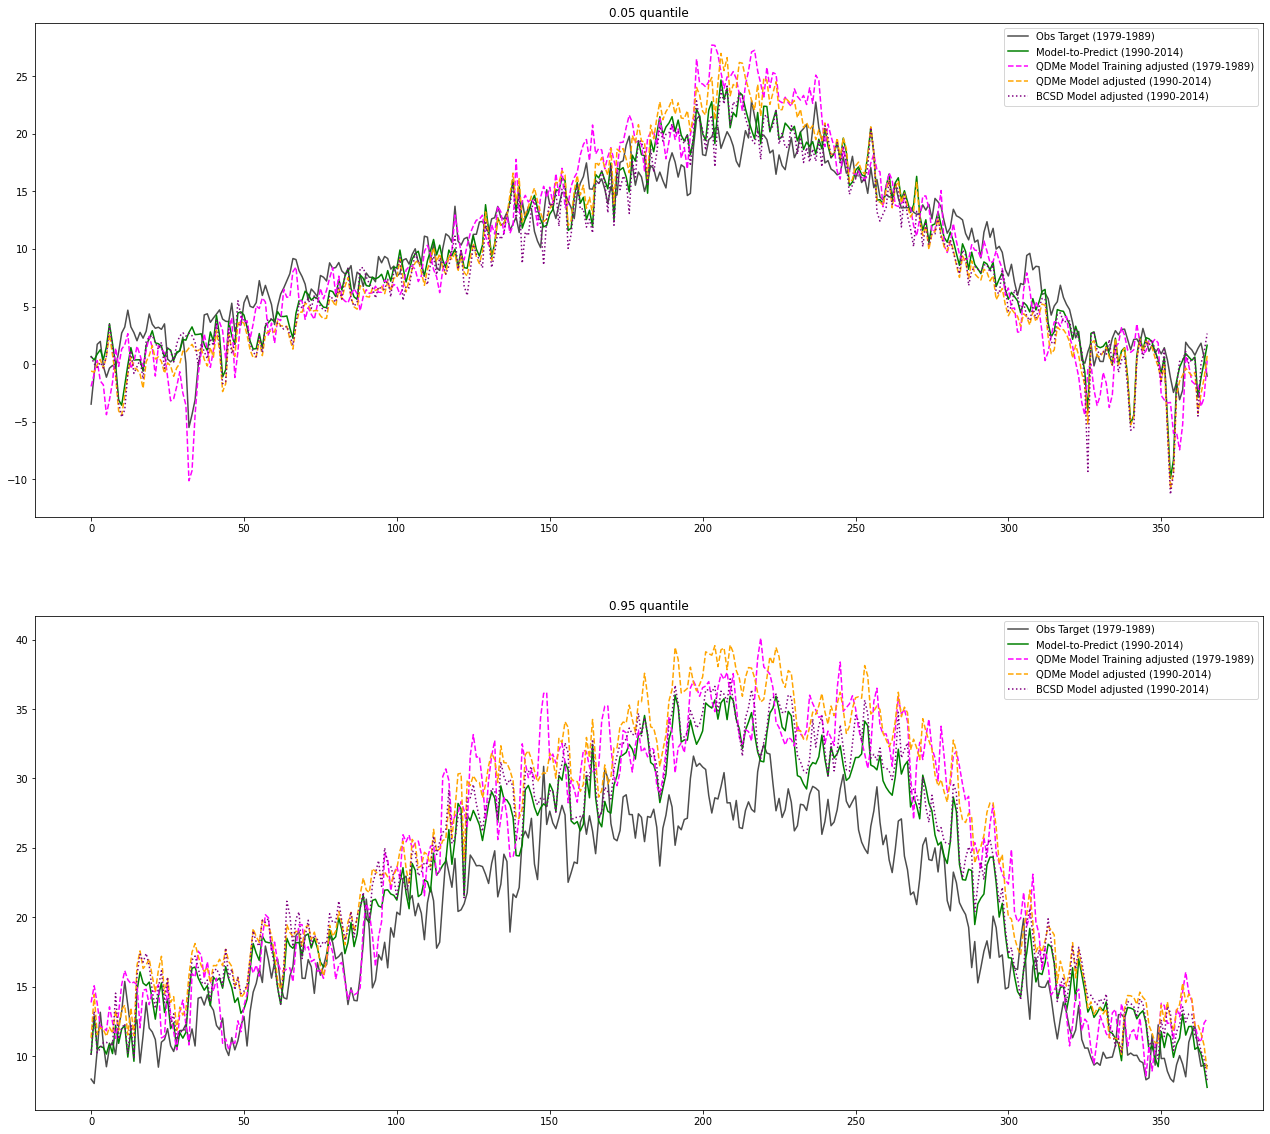

In [55]:
fig,axs = plt.subplots(2,1,figsize=(22,20))
ax=axs[0]
quant=0.05
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot(qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot(qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe'], linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['BCSDNN'], linestyle=':')
_ = ax.set_title('{} quantile'.format(quant))
ax.legend(('Obs Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDMe Model adjusted (1990-2014)',
           'BCSD Model adjusted (1990-2014)'))

ax=axs[1]
quant=.95
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot(qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot(qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe'], linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['BCSDNN'], linestyle=':')
_ = ax.set_title('{} quantile'.format(quant))
ax.legend(('Obs Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDMe Model adjusted (1990-2014)',
           'BCSD Model adjusted (1990-2014)'))


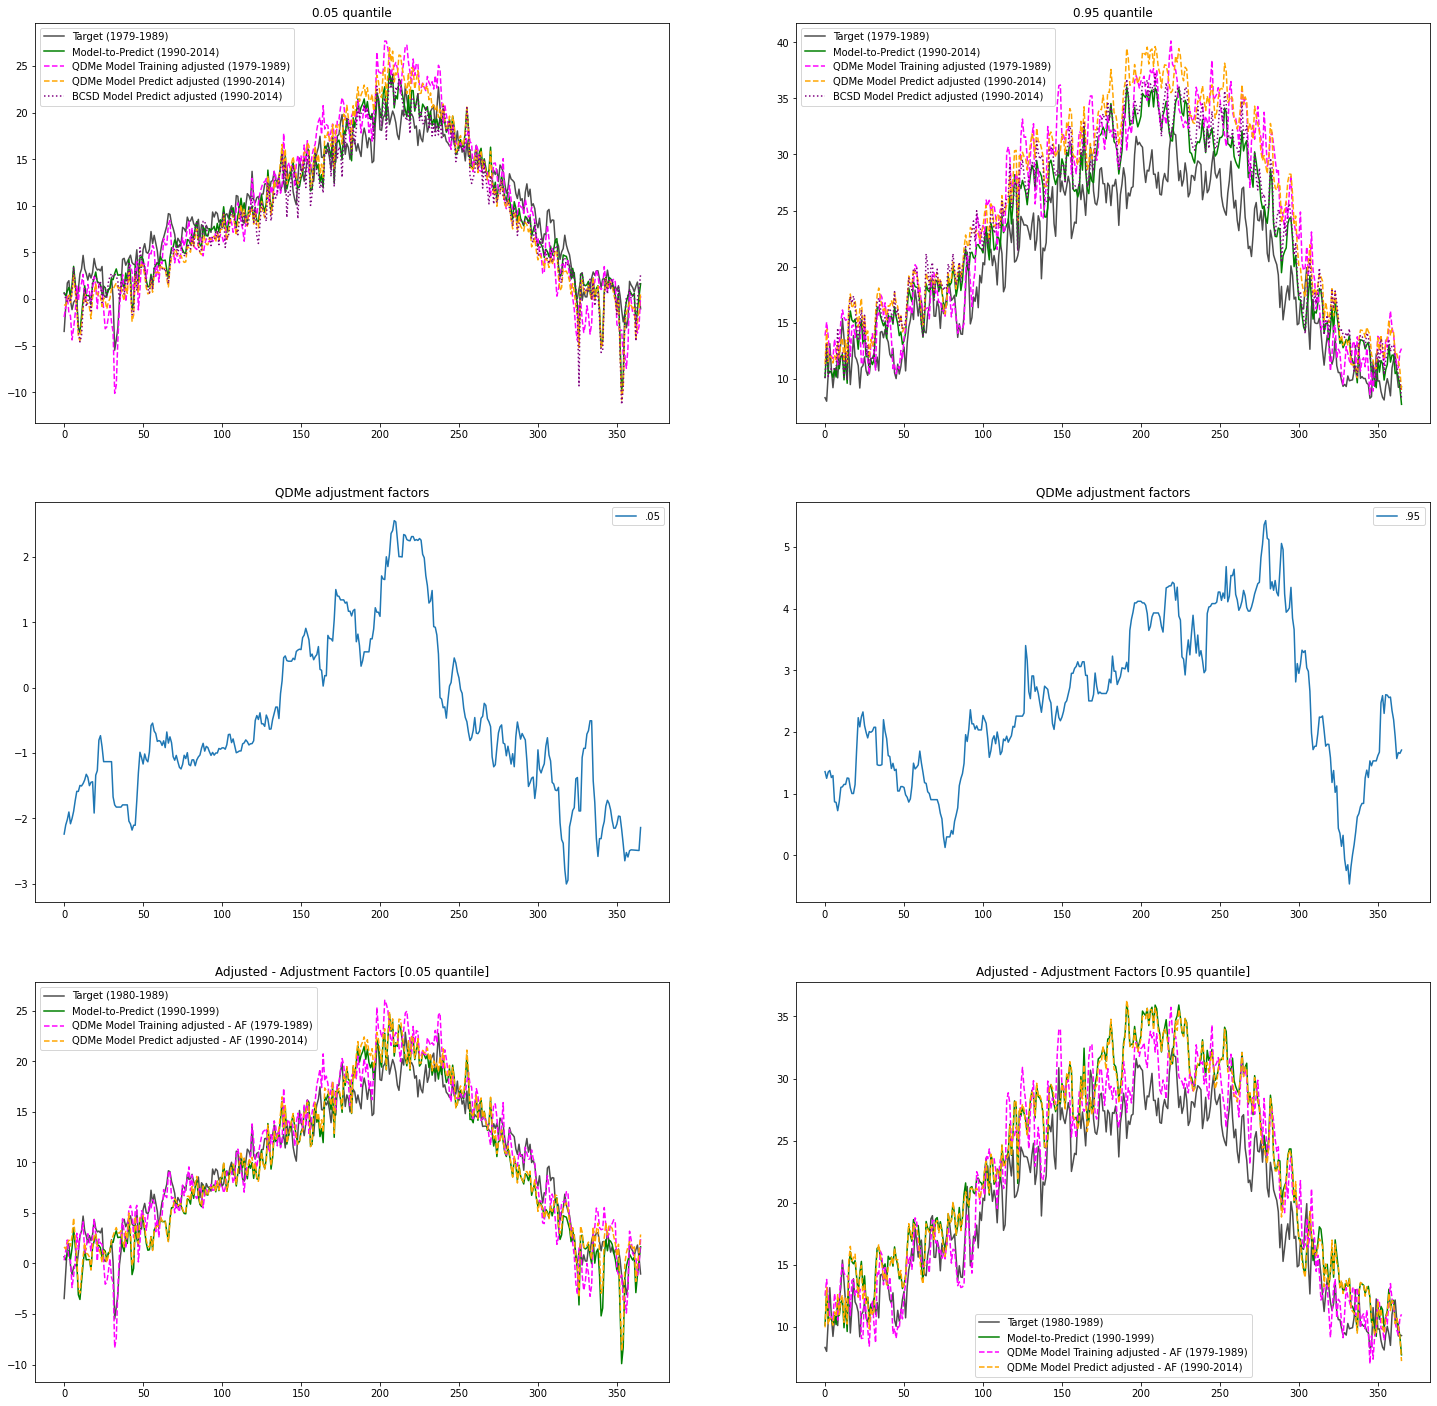

In [60]:

fig,axs = plt.subplots(3,2,figsize=(25,25))
ax=axs[0,0]
quant=0.05
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot(qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot(qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe'], linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['BCSDNN'], linestyle=':')
_ = ax.set_title('{} quantile'.format(quant))
ax.legend(('Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDMe Model Predict adjusted (1990-2014)',
           'BCSD Model Predict adjusted (1990-2014)'))

ax=axs[1,0]
# ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.05), method='nearest'))
# ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.5), method='nearest'))
ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest'))
ax.legend(('.05',))
_ = ax.set_title('QDMe adjustment factors')

ax=axs[2,0]
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot((qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time') 
        - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest')), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot((qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time')
         - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest')), color=colordt['QDMe'], linestyle='dashed')
_ = ax.set_title('Adjusted - Adjustment Factors [{} quantile]'.format(quant))
ax.legend(('Target (1980-1989)', 
           'Model-to-Predict (1990-1999)', 
           'QDMe Model Training adjusted - AF (1979-1989)',
           'QDMe Model Predict adjusted - AF (1990-2014)'))


ax=axs[0,1]
quant=0.95
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot(qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot(qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['QDMe'], linestyle='dashed')
ax.plot(bcsd_nasanex_predicted.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['BCSDNN'], linestyle=':')
_ = ax.set_title('{} quantile'.format(quant))
ax.legend(('Target (1979-1989)', 
           'Model-to-Predict (1990-2014)', 
           'QDMe Model Training adjusted (1979-1989)',
           'QDMe Model Predict adjusted (1990-2014)',
           'BCSD Model Predict adjusted (1990-2014)'))

ax=axs[1,1]
# ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.05), method='nearest'))
# ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(.5), method='nearest'))
ax.plot(qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest'))
ax.legend(('.95',))
_ = ax.set_title('QDMe adjustment factors')

ax=axs[2,1]
ax.plot(ds_target.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Target'])
ax.plot(ds_predict.groupby('time.dayofyear').quantile(quant, dim='time'), color=colordt['Predict'])
ax.plot((qdme_histadjusted_da.groupby('time.dayofyear').quantile(quant, dim='time') 
        - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest')), color=colordt['QDMe Train'], linestyle='dashed')
ax.plot((qdme_adjusted_da.groupby('time.dayofyear').quantile(quant, dim='time')
         - qdme.ds.af.sel(quantiles=qdme.ds.af.quantiles.quantile(quant), method='nearest')), color=colordt['QDMe'], linestyle='dashed')
_ = ax.set_title('Adjusted - Adjustment Factors [{} quantile]'.format(quant))
ax.legend(('Target (1980-1989)', 
           'Model-to-Predict (1990-1999)', 
           'QDMe Model Training adjusted - AF (1979-1989)',
           'QDMe Model Predict adjusted - AF (1990-2014)'))


### standard deviation of each dataset

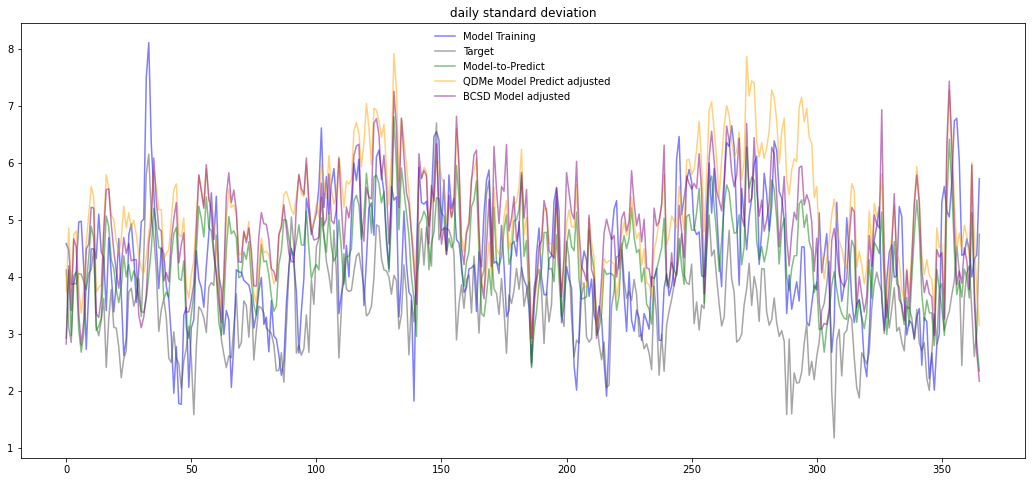

In [68]:
fig,ax = plt.subplots(1,1,figsize=(18,8))
ax.plot(ds_train.groupby('time.dayofyear').std(dim='time'), color=colordt['Train'],alpha=.5)
ax.plot(ds_target.groupby('time.dayofyear').std(dim='time'), color=colordt['Target'], alpha=.5)
ax.plot(ds_predict.groupby('time.dayofyear').std(dim='time'), color=colordt['Predict'], alpha=.5)

ax.plot(qdme_adjusted_da.groupby('time.dayofyear').std(dim='time'), color=colordt['QDMe'], alpha=.5)
ax.plot(bcsd_nasanex_predicted.groupby('time.dayofyear').std(dim='time'), color=colordt['BCSDNN'], alpha=.5)


ax.legend(('Model Training', 
           'Target', 
           'Model-to-Predict', 
           'QDMe Model Predict adjusted', 
           'BCSD Model adjusted'), frameon=False)
_ = ax.set_title('daily standard deviation')